# Group Project: Questions 2 and 3

In [ ]:
%pip install pandas
%pip install matplotlib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("..\\data\\master_table_output.csv") # The output from the data cleaning scripts

plt.style.use('default')

C:\Users\histo\AppData\Local\Temp\ipykernel_11644\20680241.py:4: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("..\\data\\master_table_output.csv") # The output from the data cleaning scripts


Calculate delay ratio, get day of the week, get year station opened, and decode weather codes here so they can be used across the entire notebook:

In [4]:
# Mapping of weather codes to weather conditions
weather_mapping = {
    1: "Clear", 2: "Fair", 3: "Cloudy", 4: "Overcast", 5: "Fog", 
    6: "Freezing Fog", 7: "Light Rain", 8: "Rain", 9: "Heavy Rain", 
    10: "Freezing Rain", 11: "Heavy Freezing Rain", 12: "Sleet", 
    13: "Heavy Sleet", 14: "Light Snowfall", 15: "Snowfall", 
    16: "Heavy Snowfall", 17: "Rain Shower", 18: "Heavy Rain Shower", 
    19: "Sleet Shower", 20: "Heavy Sleet Shower", 21: "Snow Shower", 
    22: "Heavy Snow Shower", 23: "Lightning", 24: "Hail", 
    25: "Thunderstorm", 26: "Heavy Thunderstorm", 27: "Storm"
}

# Convert 'Weather Category' from string to int
df['Weather Category'] = pd.to_numeric(df['Weather Category'], errors='coerce').astype('Int64')

# Map numeric codes to descriptive text
df['Weather Category'] = df['Weather Category'].map(weather_mapping)

# Ensure the columns have proper data types
df['Total Trip Time (hrs)'] = pd.to_numeric(df['Total Trip Time (hrs)'], errors='coerce')
df['Total Delay (min)'] = pd.to_numeric(df['Total Delay (min)'], errors='coerce')

# Calculate the delay ratio
df['Delay Ratio'] = df['Total Delay (min)'] / (df['Total Trip Time (hrs)'] * 60)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract day of the week (full name)
df['Day of Week'] = df['Date'].dt.day_name()

# Convert 'Date Opened (Arrival)' to datetime
df['Date Opened (Arrival)'] = pd.to_datetime(df['Date Opened (Arrival)'], errors='coerce')

# Extract the year
df['Year Opened'] = df['Date Opened (Arrival)'].dt.year

See if route volume correlates to an increase/decrease in delays:

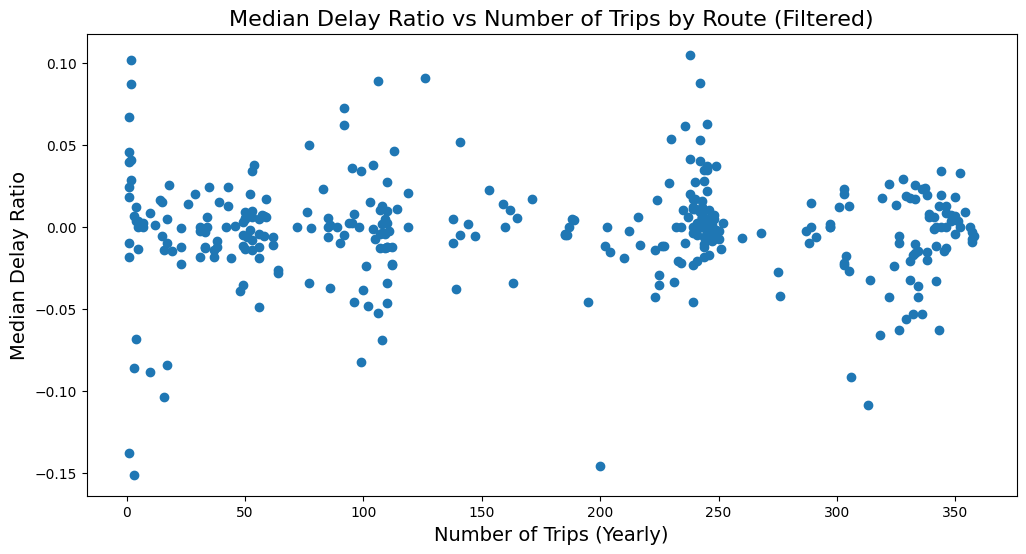

In [5]:
# Filter out outliers
filtered_df = df[df['Delay Ratio'] > -0.2]
filtered_df = filtered_df[filtered_df['Delay Ratio'] < 0.2]

# Group data by Route Number
route_stats = filtered_df.groupby('Route Number').agg(
    num_trips=('Delay Ratio', 'count'),
    median_delay_ratio=('Delay Ratio', 'median')
).reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(route_stats['num_trips'], route_stats['median_delay_ratio'])
plt.title('Median Delay Ratio vs Number of Trips by Route (Filtered)', fontsize=16)
plt.xlabel('Number of Trips (Yearly)', fontsize=14)
plt.ylabel('Median Delay Ratio', fontsize=14)
plt.show()

What does performance look like for the top 20 routes? Are the delay times fairly similar across all lines or do a few stand out?

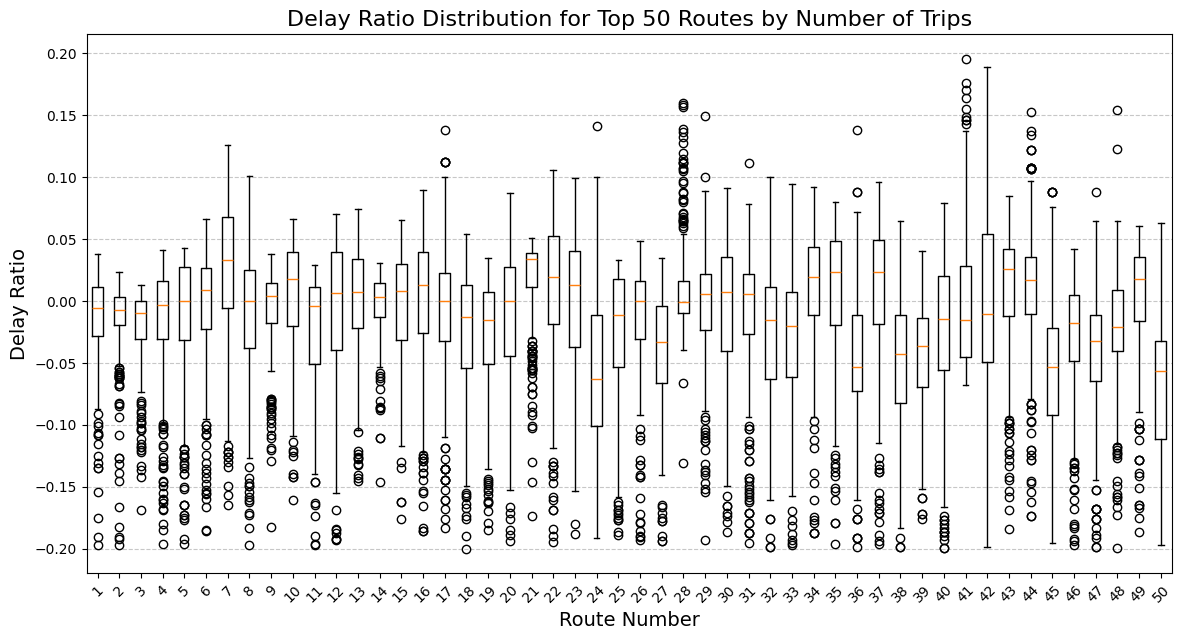

In [6]:
# Data for the top 20 routes
top_20_routes = route_stats.nlargest(50, 'num_trips')['Route Number']
top_20_data = filtered_df[filtered_df['Route Number'].isin(top_20_routes)]

# Group data by Route Number
grouped_data = [top_20_data[top_20_data['Route Number'] == route]['Delay Ratio'] for route in top_20_routes]

plt.figure(figsize=(14, 7))
plt.boxplot(grouped_data)

# Add titles and labels
plt.title('Delay Ratio Distribution for Top 50 Routes by Number of Trips', fontsize=16)
plt.xlabel('Route Number', fontsize=14)
plt.ylabel('Delay Ratio', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Does weather correlate to an increase/decrease in delay times?

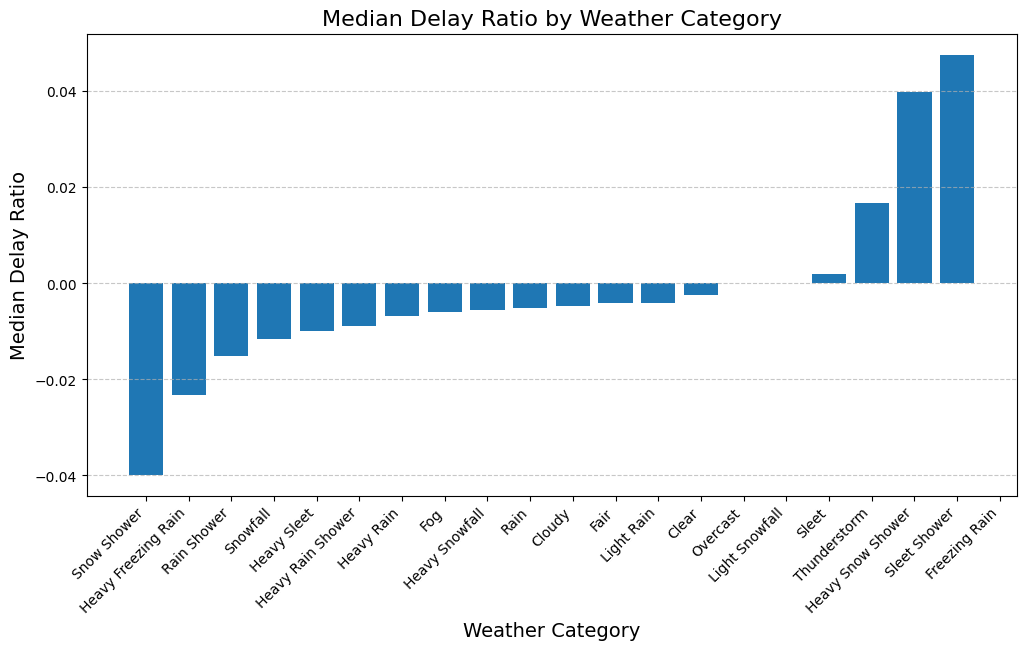

In [7]:
# Group data by Weather Category and calculate median delay ratio
weather_stats = df.groupby('Weather Category')['Delay Ratio'].median().reset_index()

# Sort data by median delay ratio for cleaner view
weather_stats = weather_stats.sort_values(by='Delay Ratio')

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(weather_stats['Weather Category'], weather_stats['Delay Ratio'])
plt.title('Median Delay Ratio by Weather Category', fontsize=16)
plt.xlabel('Weather Category', fontsize=14)
plt.ylabel('Median Delay Ratio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


Promising results, extreme weather events seem to have significantly higher delay times.

Does day of the week correlate to an increase/decrease in delay times?

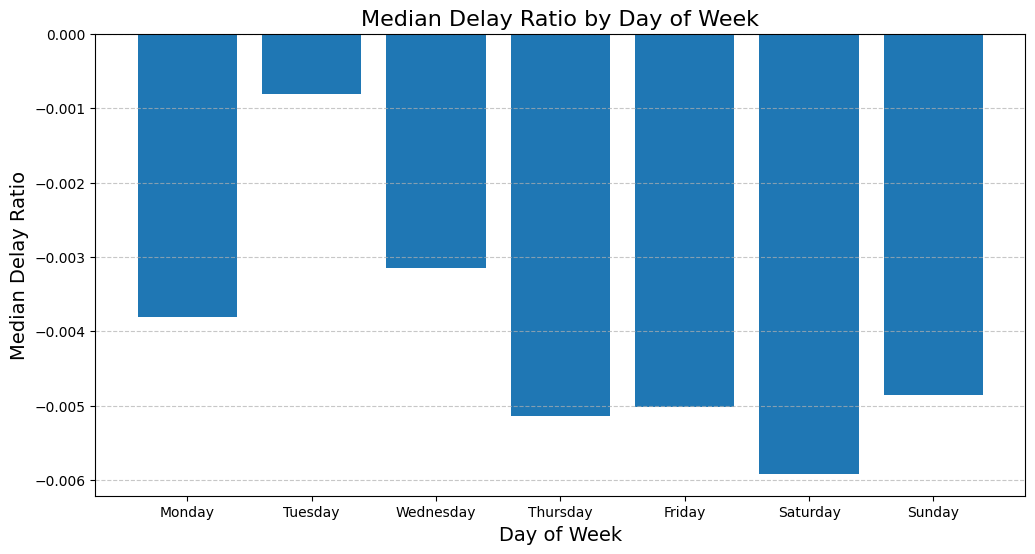

In [8]:
# Group data by Day of Week and calculate median delay ratio
day_stats = df.groupby('Day of Week')['Delay Ratio'].median().reset_index()

# Sort days of the week in correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats['Day of Week'] = pd.Categorical(day_stats['Day of Week'], categories=day_order, ordered=True)
day_stats = day_stats.sort_values(by='Day of Week')


# Bar
plt.figure(figsize=(12, 6))
plt.bar(day_stats['Day of Week'], day_stats['Delay Ratio'])
plt.title('Median Delay Ratio by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Median Delay Ratio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Does the year the station opened correlate to an increase/decrease in delay times?

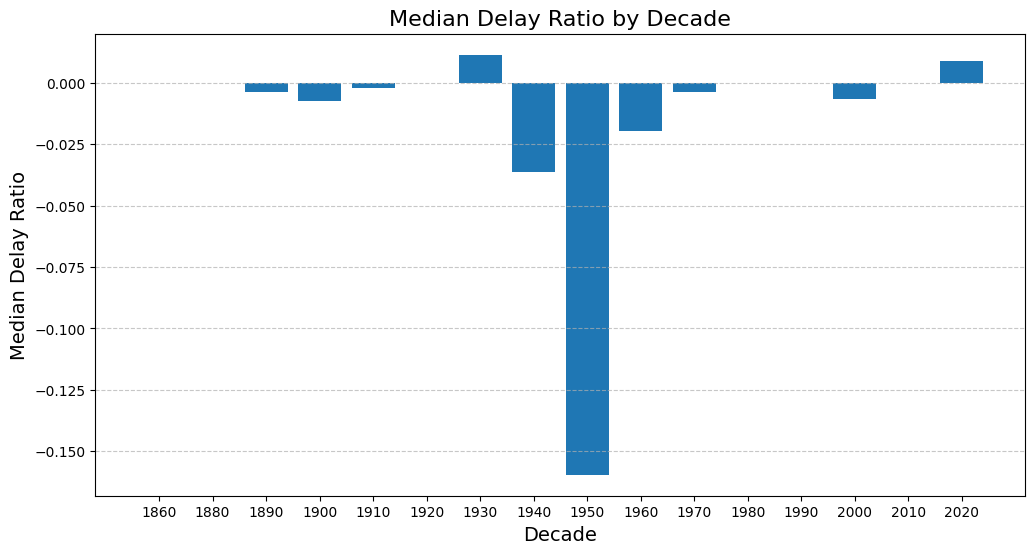

In [9]:
# Group data by decade and calculate median delay ratio
df['Decade'] = (df['Year Opened'] // 10) * 10  # Group by decade
day_stats = df.groupby('Decade')['Delay Ratio'].median().reset_index()

# Count the number of samples for each decade
sample_counts = df.groupby('Decade').size().reset_index(name='Sample Count')

# Merge the sample counts with the day_stats
day_stats = pd.merge(day_stats, sample_counts, on='Decade')

#Don't keep it as float, not clean
day_stats['Decade'] = day_stats['Decade'].astype(int)

# Bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(day_stats['Decade'].astype(str), day_stats['Delay Ratio'])

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Median Delay Ratio by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Median Delay Ratio', fontsize=14)
plt.show()



While we do have this giant outlier here around 1950, if it was really a defect of this time period the curve would be softer instead of this giant spike.

Does the state the train is headed to result in an increase/decrease in delay times?

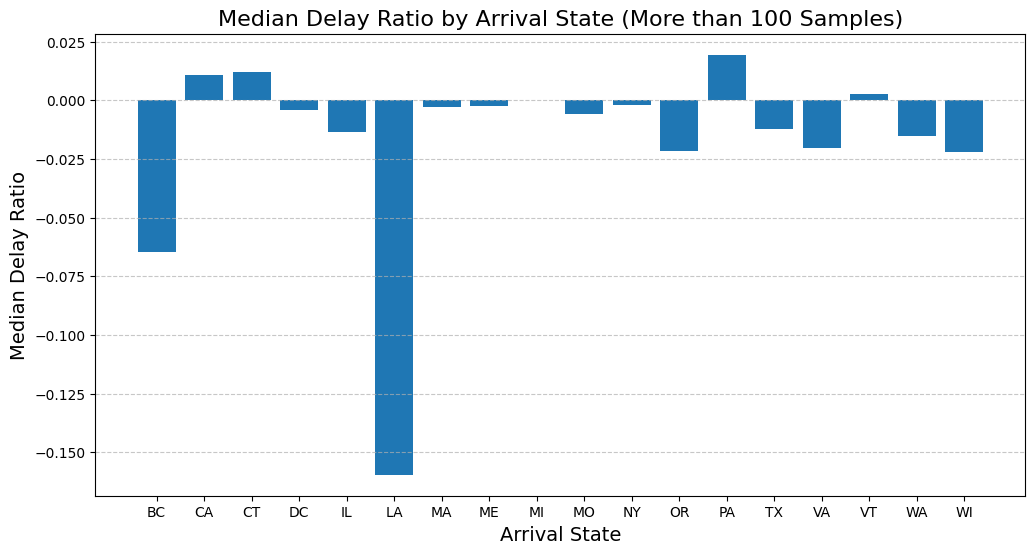

In [10]:
# Calculate sample counts for each State
sample_counts = df.groupby('Arrival State').size().reset_index(name='Sample Count')

# Group by State and calculate median delay ratio
state_stats = df.groupby('Arrival State')['Delay Ratio'].median().reset_index()

# Merge sample counts with state_stats
state_stats = pd.merge(state_stats, sample_counts, on='Arrival State')

# Filter to include only states with more than 100 samples
filtered_state_stats = state_stats[state_stats['Sample Count'] > 100]

# Sort by alphabetical order
filtered_state_stats = filtered_state_stats.sort_values(by='Arrival State')

# Bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_state_stats['Arrival State'], filtered_state_stats['Delay Ratio'])

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Median Delay Ratio by Arrival State (More than 100 Samples)', fontsize=16)
plt.xlabel('Arrival State', fontsize=14)
plt.ylabel('Median Delay Ratio', fontsize=14)
plt.show()


This might be a good way to look at a few more complex issues that are hard to get concrete numbers on. Many of the southern states that don't invest in train infrastructure have high delays, and many of the states that have a lot of freight traffic have an increase in delays. West coast states that invest a lot in passenger rail infrastructure also have lower delay times.